# BraTS preprocessing workflow

Many [BraTS](https://www.synapse.org/brats) datasets are provided as skullstripped images in SRI24 space. This notebook provides a workflow to process raw scans to this format.

#### Requirements

For this workflow make sure you have [SimpleITK-SimpleElastix](https://pypi.org/project/SimpleITK-SimpleElastix) and [HD-BET](https://github.com/MIC-DKFZ/HD-BET) installed, both are available via pip and work on both Windows and Linux.

#### Data
For this example we download some MRIs from https://zenodo.org/records/7213153 in DICOM format.

Colin Vanden Bulcke. (2022). Open-Access DICOM MRI session (1.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7213153

['s16342', 's16335', 's16343', 's16329', 's16341', 's16340', 's16336', 's16337', 's16328', 's16330']


ImageSeriesReader (0x556f5b7a6d20): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000801425

ImageSeriesReader (0x556f5b7a6d20): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.000801425

ImageSeriesReader (0x556f5b7a6d20): Non uniform sampling or missing slices detected,  maximum nonuniformity:232.027

ImageSeriesReader (0x556f5b7a6d20): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.501614



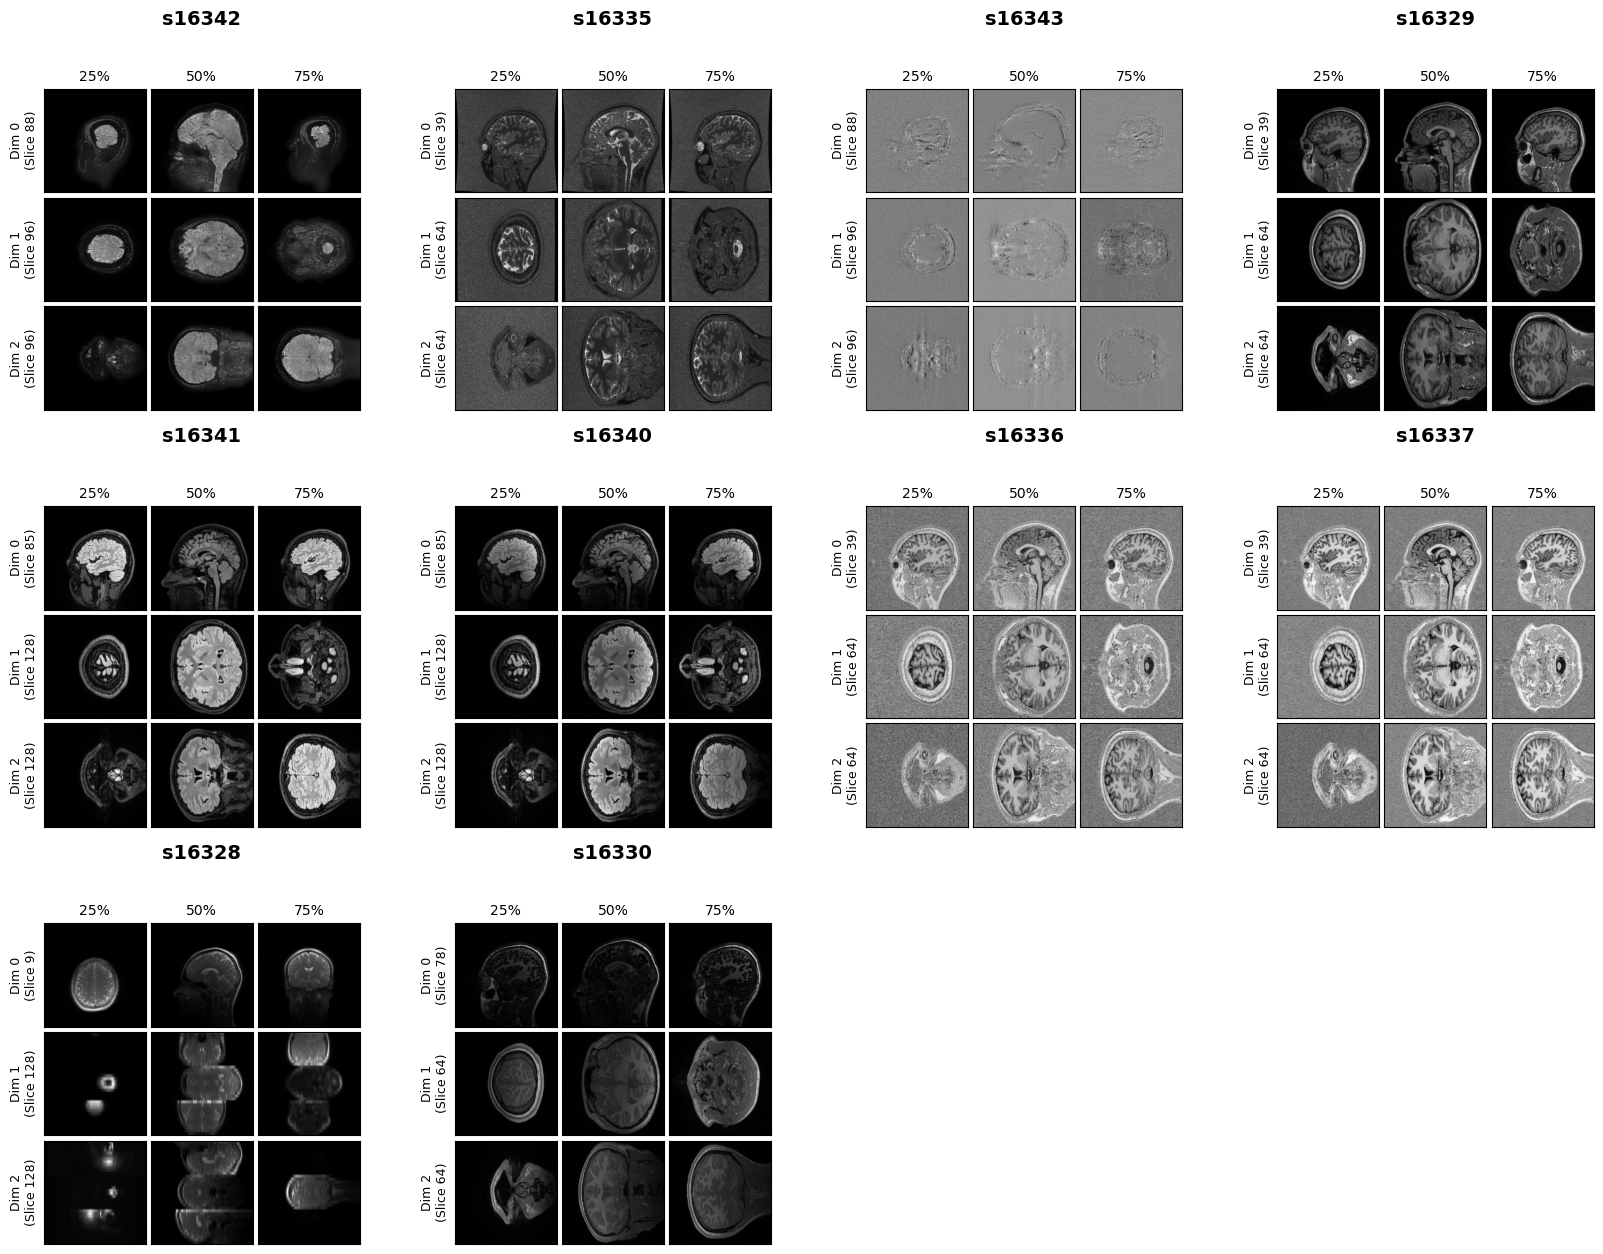

In [1]:
# uncoment if running on Colab or Kaggle
# !pip install mrid
# !pip install hd-bet # for skullstripping
# !pip install SimpleITK-SimpleElastix # for registration

# note that since the download is large, this script may fail or download corrupted ZIP. 
# In this case you can try downloading it manually from your browser or use any other MRIs you have.

import os, shutil, requests
from pathlib import Path

if "BMAT_MRI_session" not in os.listdir("data"):

    # download
    if "BMAT_MRI_session.zip" not in os.listdir("data"):
        response = requests.get("https://zenodo.org/records/7213153/files/BMAT_MRI_session.zip?download=1", stream=True)
        response.raise_for_status()
        with open("data/BMAT_MRI_session.zip", 'wb') as file:
            shutil.copyfileobj(response.raw, file) # type:ignore

    # unpack
    shutil.unpack_archive("data/BMAT_MRI_session.zip", "data")

ROOT = Path("data/BMAT_MRI_session/export/home1/sdc_image_pool/images/p883/e1007")
print(os.listdir(ROOT))

import mrid
mrid.utils.plot_study({dir: ROOT / dir for dir in os.listdir(ROOT)})

We'll load the standard set of T1 (t1n), post-contrast T1 (t1c), FLAIR (t2f) and T2w.

ImageSeriesReader (0x7fc584000c60): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.501614



t1c: (156, 256, 256)
t1n: (312, 256, 256)
t2f: (340, 512, 512)
t2w: (156, 256, 256)


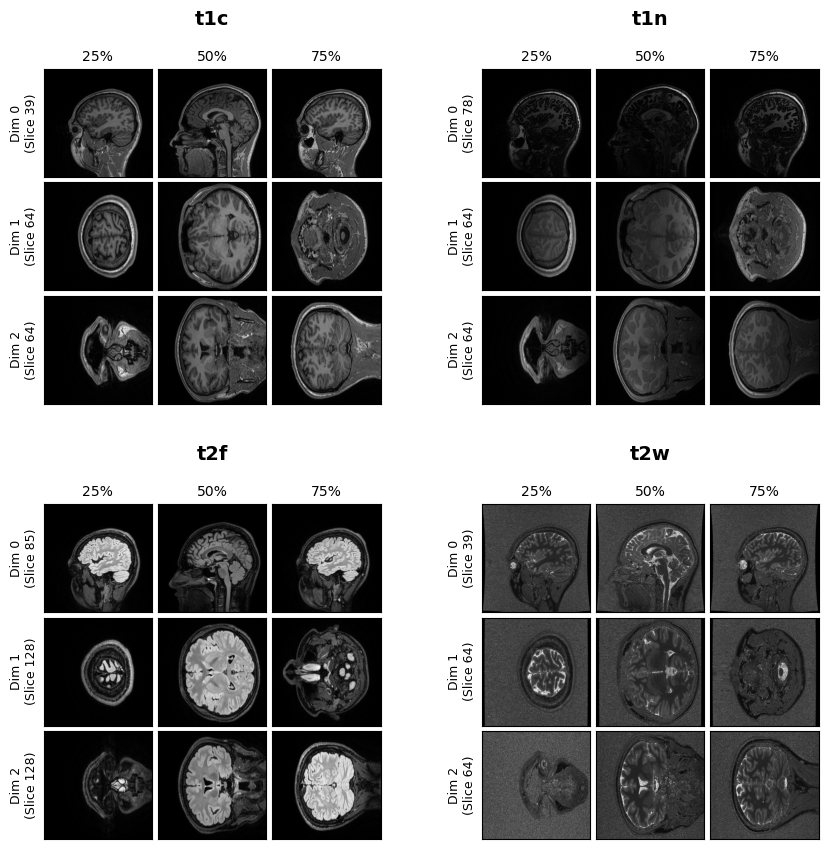

In [6]:
study = mrid.Study(t1c=ROOT/"s16329", t1n=ROOT/"s16330", t2f=ROOT/"s16341", t2w=ROOT/"s16335")

for k,v in study.numpy_dict().items():
    print(f"{k}: {v.shape}")

study.plot()

#### Preprocessing

Now we can preprocess it by registering to SRI24 and skullstripping.

Since the images have different shapes, we'll have to align them to each other via `register_each_SE` method.


########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

There are 1 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict

Predicting output_bet.nii.gz:
perform_everything_on_device: True


100%|██████████| 12/12 [05:28<00:00, 27.34s/it]


sending off prediction to background worker for resampling and export
done with output_bet.nii.gz


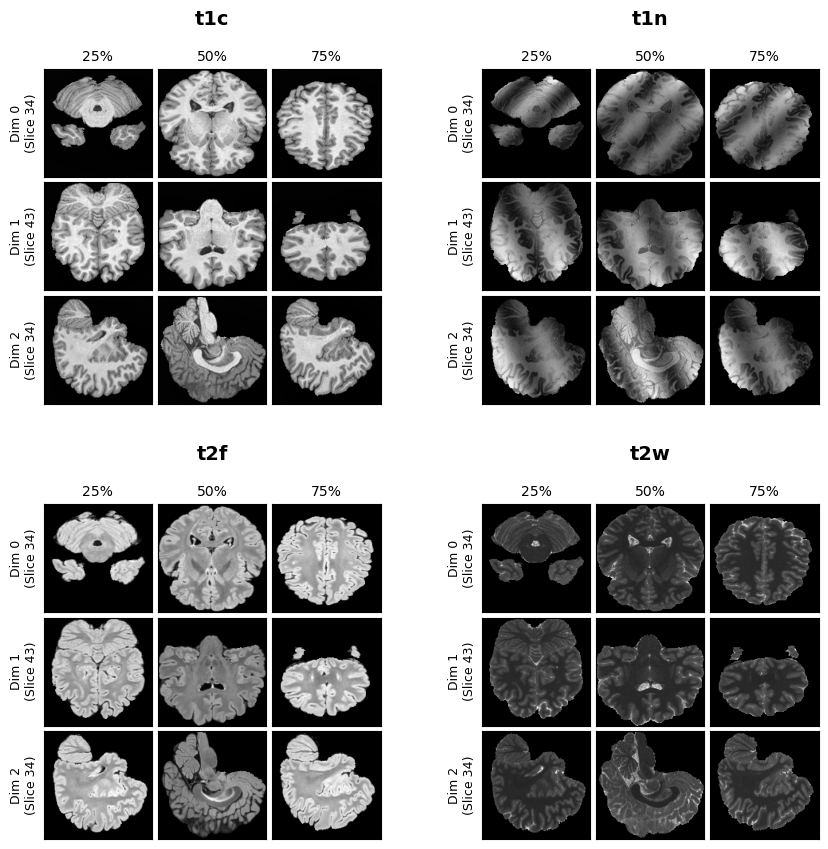

In [20]:
study_prep = (
    study

    # register t1c to SRI24 and register all other modalities to t1c
    .register_each_SE("t1c", to=mrid.get_sri24(type="T1"))

    # pass t1c to HD-BET, which requires scans to be in MNI152, so we set register_to_mni152="T1"
    # the predicted brain mask is then applied to all modalities
    # this takes a few minutes. If you'd like to speed this up,
    # use skullstrip_synthstrip instead, which requires SynthStrip to be installed
    .skullstrip_hd_bet("t1c", register_to_mni152="T1")

    # optionally perform N4 bias field correction, although BraTS usually doesn't do that
    .n4_bias_field_correction("t1c")
    .n4_bias_field_correction("t2f")

    # also optionally crop to foreground, this removes black background
    # we determine bounding box on t1c and use it to crop all scans
    # BraTS doesn't do that, but you can do this to speed up inference if you predict in patches.
    .crop_bg("t1c")

    # standardize each scan, so that mean=0 and std=1
    .normalize()
)

study_prep.plot()

If you are wondering why T1n looks like this, that's just how the original scan looks. We can zoom into the raw scan to see the interference pattern better. Registering the scan rotates the interference pattern so it appears as having larger scale.

[]

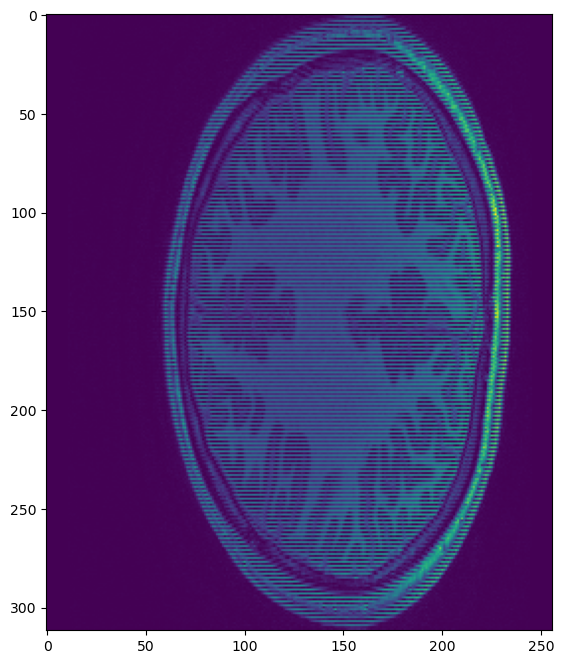

In [18]:
import matplotlib.pyplot as plt

plt.imshow(study.numpy("t1n")[:, 96, :])
plt.gcf().set_size_inches(8, 8)
plt.plot()

#### Saving
If you'd like to save the study for later, use `study.save(out_dir)`. It will be saved to a directory with `*.nii.gz` files. You can then use `study = Study.from_dir(out_dir)` to load the saved study. 

Note that code above also works with segmentations provided they have keys starting with `"seg"`, e.g. `"seg_ET"`, in the `Study`. The segmentations will not be affected by skullstripping and normalization, and use nearest neighbour interpolation during registration. So this way you can preprocess a dataset with manual segmentations to BraTS format.

#### Converting study to an array

You can convert any value in a study to torch tensor by using `study.tensor(key)`, e.g. `study.tensor("t1c")`.

Or `study.numpy(key)` to get a numpy array.

You can also convert study to a dictionary of numpy arrays or torch tensors via `study.numpy_dict()` and `study.tensor_dict()`.

Finally we can stack scans in a study along first dimension using `study.stack_numpy()` or `study.stack_tensor()`.

In [19]:
# if order is not specified, scans are stacked in alphabetical order
# make sure to use the correct order for your model!
input_tensor = study_prep.stack_tensor(order=("t1n", "t1c", "t2f", "t2w"))

input_tensor.shape

torch.Size([4, 137, 175, 137])